# Noise-Aware Demo
Run the next cell to train the noise-aware qnn moons model (T1=80 µs, T2=120 µs) and plot loss/accuracy.

In [3]:
import sys
sys.path.insert(0, '..')

# Minimal noise-aware run + plot
from qml_training import train, EncodingType
from visualizer import plot_training_curves


MOONS | NOISE_AWARE | Epoch 01 | Loss 1.3874 | Acc 0.520
MOONS | NOISE_AWARE | Epoch 02 | Loss 1.3634 | Acc 0.527
MOONS | NOISE_AWARE | Epoch 03 | Loss 1.3407 | Acc 0.527
MOONS | NOISE_AWARE | Epoch 04 | Loss 1.3194 | Acc 0.527
MOONS | NOISE_AWARE | Epoch 05 | Loss 1.2995 | Acc 0.520
MOONS | NOISE_AWARE | Epoch 06 | Loss 1.2810 | Acc 0.547
MOONS | NOISE_AWARE | Epoch 07 | Loss 1.2640 | Acc 0.540
MOONS | NOISE_AWARE | Epoch 08 | Loss 1.2483 | Acc 0.520
MOONS | NOISE_AWARE | Epoch 09 | Loss 1.2341 | Acc 0.520
MOONS | NOISE_AWARE | Epoch 10 | Loss 1.2212 | Acc 0.527
MOONS | NOISE_AWARE | Epoch 11 | Loss 1.2095 | Acc 0.547
MOONS | NOISE_AWARE | Epoch 12 | Loss 1.1990 | Acc 0.547
MOONS | NOISE_AWARE | Epoch 13 | Loss 1.1895 | Acc 0.560
MOONS | NOISE_AWARE | Epoch 14 | Loss 1.1810 | Acc 0.567
MOONS | NOISE_AWARE | Epoch 15 | Loss 1.1734 | Acc 0.567
  Plot saved: noise_aware_moons_t1200_t2250_eprange(1, 16)_20_1347.png


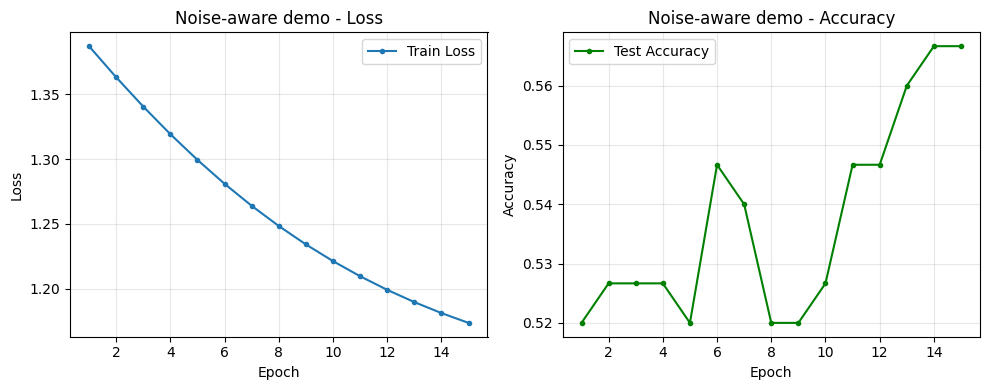

In [1]:
epochs = 15

# microseconds
T1=200.0
T2=250.0

# Small demo run, moons, with T1/T2 noise
metrics = train(
    model_type="noise_aware",
    encoding=EncodingType.ANGLE,
    dataset="moons",
    epochs=epochs,
    record_metrics=True,
    T1=T1,
    T2=T2,
)

plot_training_curves(
    metrics["loss_history"],
    metrics["acc_history"],
    dataset="moons",
    model_type="noise_aware",
    title="Noise-aware demo",
    save=True,
    T1=T1,
    T2=T2,
    epochs=epochs,
)


In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, Circle, FancyArrowPatch
import math

# Import our quantum simulator components
from quantum_simulator import (
    zero_state, custom_state, apply_gate, apply_circuit_to_ket,
    state_to_density, run_noisy_circuit_density, measure,
    RY, RZ, RX, CNOT, H, X, Z, I2
)
from qml_training import (
    EncodingType, state_encoding, quantum_feature_map,
    param_gate_layer
)
from error_kraus import thermal_relaxation_error_rate, add_time_based_noise

## Circuit Visualization Helpers

Custom visualization functions to draw quantum circuits in a clean, readable format.

In [5]:
def draw_circuit(circuit, num_qubits, title="Quantum Circuit", figsize=(12, 3)):
    """
    Draw a quantum circuit diagram.
    
    circuit: List of (gate_name, [qubits], param?) tuples
    num_qubits: Number of qubits
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Layout parameters
    wire_spacing = 1.0
    gate_width = 0.6
    gate_spacing = 1.2
    start_x = 1.0
    
    # Draw qubit wires
    max_x = start_x + len(circuit) * gate_spacing + 1
    for q in range(num_qubits):
        y = (num_qubits - 1 - q) * wire_spacing
        ax.hlines(y, 0, max_x, colors='black', linewidth=1)
        ax.text(-0.3, y, f'q{q}', fontsize=12, ha='right', va='center', fontweight='bold')
    
    # Gate colors
    gate_colors = {
        'RY': '#4CAF50',  # Green
        'RZ': '#2196F3',  # Blue
        'RX': '#FF9800',  # Orange
        'H': '#9C27B0',   # Purple
        'X': '#E91E63',   # Pink
        'CNOT': '#607D8B', # Gray
        'T1T2_NOISE': '#F44336',  # Red for noise
    }
    
    # Draw gates
    for i, op in enumerate(circuit):
        x = start_x + i * gate_spacing
        gate_name = op[0]
        qubits = op[1]
        param = op[2] if len(op) > 2 else None
        
        color = gate_colors.get(gate_name, '#9E9E9E')
        
        if gate_name == 'CNOT':
            # Draw CNOT gate
            ctrl_y = (num_qubits - 1 - qubits[0]) * wire_spacing
            targ_y = (num_qubits - 1 - qubits[1]) * wire_spacing
            
            # Control dot
            ax.plot(x, ctrl_y, 'ko', markersize=10)
            # Vertical line
            ax.vlines(x, min(ctrl_y, targ_y), max(ctrl_y, targ_y), colors='black', linewidth=2)
            # Target circle with X
            circle = plt.Circle((x, targ_y), 0.2, fill=False, linewidth=2, color='black')
            ax.add_patch(circle)
            ax.vlines(x, targ_y - 0.2, targ_y + 0.2, colors='black', linewidth=2)
            ax.hlines(targ_y, x - 0.2, x + 0.2, colors='black', linewidth=2)
            
        elif gate_name == 'T1T2_NOISE':
            # Draw noise operator (wavy box) with λ1, λ2, and time info
            λ1 = op[2] if len(op) > 2 else 0
            λ2 = op[3] if len(op) > 3 else 0
            idle_time = op[4] if len(op) > 4 else 0
            for q in qubits:
                y = (num_qubits - 1 - q) * wire_spacing
                # Make box wider to fit text
                noise_width = gate_width * 1.8
                rect = FancyBboxPatch(
                    (x - noise_width/2, y - 0.35), noise_width, 0.7,
                    boxstyle="round,pad=0.05", facecolor=color, edgecolor='darkred',
                    linewidth=2, alpha=0.8, linestyle='--'
                )
                ax.add_patch(rect)
                # Display noise parameters: λ1, λ2, and time
                noise_label = f"λ₁={λ1:.3f}\nλ₂={λ2:.3f}\nt={idle_time:.1f}"
                ax.text(x, y, noise_label, fontsize=6, ha='center', va='center', 
                        color='white', fontweight='bold')
        else:
            # Draw single/multi-qubit gate box
            for q in qubits:
                y = (num_qubits - 1 - q) * wire_spacing
                rect = FancyBboxPatch(
                    (x - gate_width/2, y - 0.3), gate_width, 0.6,
                    boxstyle="round,pad=0.05", facecolor=color, edgecolor='black',
                    linewidth=1.5
                )
                ax.add_patch(rect)
                
                # Gate label
                label = gate_name
                if param is not None:
                    if isinstance(param, (int, float)):
                        label = f"{gate_name}\n({param:.2f})"
                    elif isinstance(param, torch.Tensor):
                        label = f"{gate_name}\n({param.item():.2f})"
                ax.text(x, y, label, fontsize=8, ha='center', va='center', 
                        color='white', fontweight='bold')
    
    ax.set_xlim(-0.5, max_x)
    ax.set_ylim(-0.5, num_qubits * wire_spacing)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
    
    plt.tight_layout()
    return fig, ax

def format_list(values, sig_figs=3):
    """Format a list of numbers with specified significant figures.
    
    Args:
        values: List or tensor of numbers
        sig_figs: Number of significant figures (default: 3)
    
    Returns:
        Formatted string like "[0.5, -0.3, 1.23]"
    """
    if hasattr(values, 'tolist'):  # Handle torch tensors
        values = values.tolist()
    formatted = ', '.join([f"{val:.{sig_figs}g}" for val in values])
    return f"[{formatted}]"
# print(f"Input: x = {format_list(x_kernel)}")


---
## 1. State Encoding Methods

We support two encoding types:
- **Angle Encoding**: Each feature maps to a rotation angle on a qubit (RY gate)
- **Amplitude Encoding**: Features are encoded directly as state amplitudes

=== ANGLE ENCODING ===
Input features: [0.5, -0.8]

Circuit operations:
  ('RY', [0], tensor(0.5000))
  ('RY', [1], tensor(-0.8000))


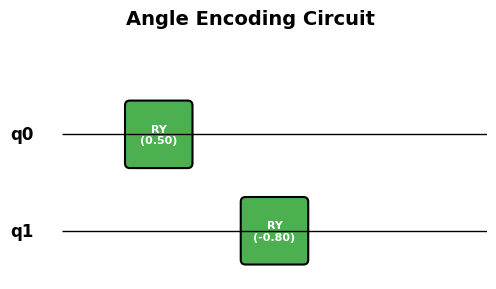

In [6]:
# Example: Angle Encoding for 2 qubits
n_qubits = 2
x_angle = torch.tensor([0.5, -0.8])  # Two features → two qubits

# Get the encoding circuit
state_angle, circuit_angle = state_encoding(x_angle, n_qubits, encoding=EncodingType.ANGLE)

print("=== ANGLE ENCODING ===")
print(f"Input features: {format_list(x_angle)}")
print(f"\nCircuit operations:")
for op in circuit_angle:
    print(f"  {op}")

# Visualize
draw_circuit(circuit_angle, n_qubits, title="Angle Encoding Circuit")
plt.show()

=== AMPLITUDE ENCODING ===
Input features: [0.5, 0.3, 0.7, 0.2]

Initial state (normalized amplitudes):
  |ψ⟩ = [0.536+0j, 0.322+0j, 0.75+0j, 0.214+0j]

Circuit operations: None (state preparation only)


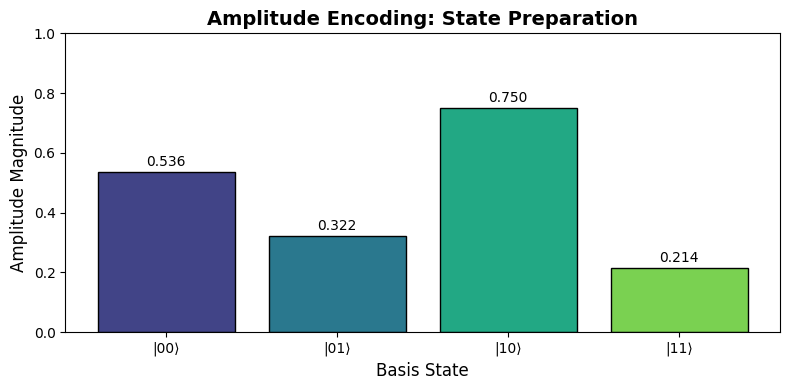

In [7]:
# Example: Amplitude Encoding for 2 qubits
# Need 2^2 = 4 amplitudes for 2 qubits
x_amplitude = torch.tensor([0.5, 0.3, 0.7, 0.2])

state_amp, circuit_amp = state_encoding(x_amplitude, n_qubits, encoding=EncodingType.AMPLITUDE)

print("=== AMPLITUDE ENCODING ===")
print(f"Input features: {format_list(x_amplitude)}")
print(f"\nInitial state (normalized amplitudes):")
print(f"  |ψ⟩ = {format_list(state_amp.numpy())}")
print(f"\nCircuit operations: {circuit_amp if circuit_amp else 'None (state preparation only)'}")

# Visualize state as bar chart
fig, ax = plt.subplots(figsize=(8, 4))
basis_labels = ['|00⟩', '|01⟩', '|10⟩', '|11⟩']
amplitudes = torch.abs(state_amp).numpy()
colors = plt.cm.viridis(np.linspace(0.2, 0.8, 4))
ax.bar(basis_labels, amplitudes, color=colors, edgecolor='black')
ax.set_ylabel('Amplitude Magnitude', fontsize=12)
ax.set_xlabel('Basis State', fontsize=12)
ax.set_title('Amplitude Encoding: State Preparation', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1)
for i, v in enumerate(amplitudes):
    ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=10)
plt.tight_layout()
plt.show()

### Encoding Comparison: Measurement Distributions

Let's compare how the same data looks under different encodings.

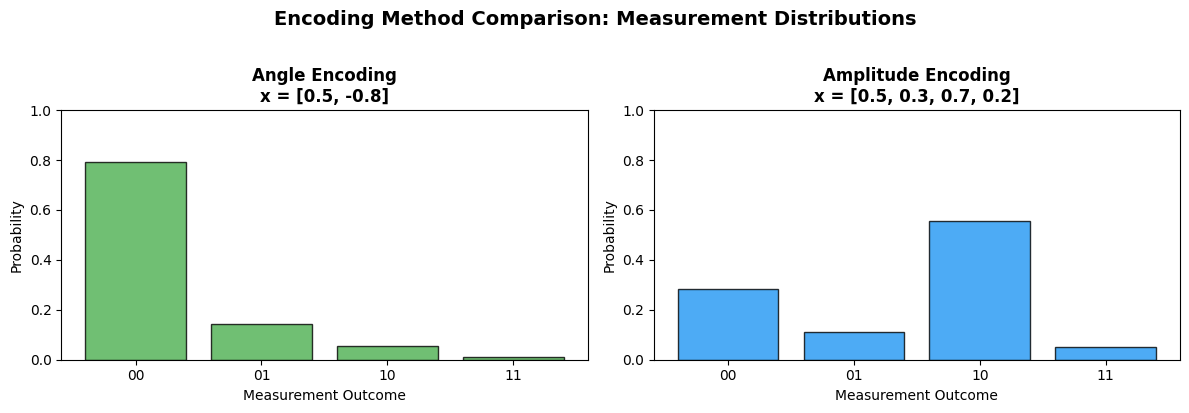

In [8]:
# Apply the circuits and measure
SHOTS = 2000

# Angle encoding: apply the RY circuit
final_state_angle = apply_circuit_to_ket(state_angle, circuit_angle, n_qubits)
counts_angle = measure(final_state_angle, shots=SHOTS)

# Amplitude encoding: state is already prepared
counts_amp = measure(state_amp, shots=SHOTS)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

basis_labels = ['00', '01', '10', '11']

# Angle encoding
ax = axes[0]
values = [counts_angle.get(b, 0) / SHOTS for b in basis_labels]
ax.bar(basis_labels, values, color='#4CAF50', edgecolor='black', alpha=0.8)
ax.set_title(f'Angle Encoding\nx = {format_list(x_angle)}', fontsize=12, fontweight='bold')
ax.set_ylabel('Probability')
ax.set_xlabel('Measurement Outcome')
ax.set_ylim(0, 1)

# Amplitude encoding
ax = axes[1]
values = [counts_amp.get(b, 0) / SHOTS for b in basis_labels]
ax.bar(basis_labels, values, color='#2196F3', edgecolor='black', alpha=0.8)
ax.set_title(f'Amplitude Encoding\nx = {format_list(x_amplitude)}', fontsize=12, fontweight='bold')
ax.set_ylabel('Probability')
ax.set_xlabel('Measurement Outcome')
ax.set_ylim(0, 1)

plt.suptitle('Encoding Method Comparison: Measurement Distributions', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 2. Quantum Kernel Feature Map

The quantum kernel uses a feature map that includes:
1. State encoding (RY gates for angle encoding)
2. Entanglement layer (CNOT)

=== QUANTUM KERNEL FEATURE MAP ===
Input: x = [0.7, -0.3]

Circuit structure:
  Layer 1: ('RY', [0], tensor(0.7000))
  Layer 2: ('RY', [1], tensor(-0.3000))
  Layer 3: ('CNOT', [0, 1])


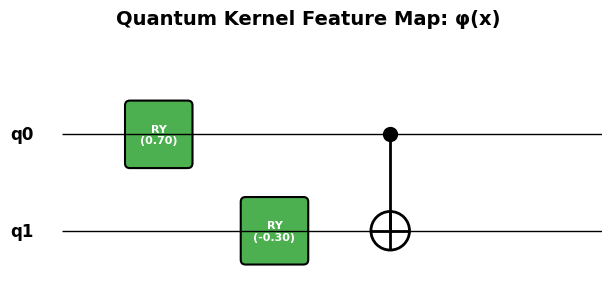

In [9]:
# Build the quantum kernel feature map circuit
x_kernel = torch.tensor([0.7, -0.3])

# The feature map: RY encoding + CNOT entanglement
kernel_circuit = param_gate_layer("RY", x_kernel)  # Encoding layer
kernel_circuit += [("CNOT", [0, 1])]  # Entanglement

print("=== QUANTUM KERNEL FEATURE MAP ===")
print(f"Input: x = {format_list(x_kernel)}")

print(f"\nCircuit structure:")
for i, op in enumerate(kernel_circuit):
    print(f"  Layer {i+1}: {op}")

draw_circuit(kernel_circuit, n_qubits, title="Quantum Kernel Feature Map: φ(x)")
plt.show()

=== QUANTUM KERNEL VALUES ===
k(x₁, x₁) = 1.0000  (self-similarity, should be ~1.0)
k(x₁, x₂) = 0.9969  (similar points)
k(x₁, x₃) = 0.4881  (different points)


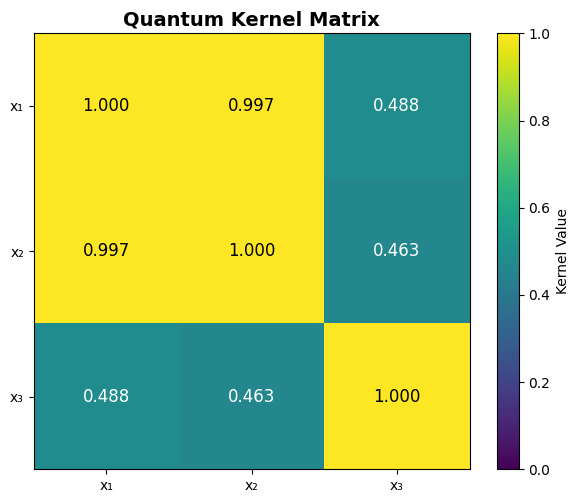

In [10]:
# Compute kernel value between two data points
from qml_training import quantum_kernel

x1 = torch.tensor([0.5, 0.3])
x2 = torch.tensor([0.6, 0.25])
x3 = torch.tensor([-0.8, -0.7])

k_11 = quantum_kernel(x1, x1)
k_12 = quantum_kernel(x1, x2)
k_13 = quantum_kernel(x1, x3)

print("=== QUANTUM KERNEL VALUES ===")
print(f"k(x₁, x₁) = {k_11:.4f}  (self-similarity, should be ~1.0)")
print(f"k(x₁, x₂) = {k_12:.4f}  (similar points)")
print(f"k(x₁, x₃) = {k_13:.4f}  (different points)")

# Visualize as heatmap
points = [x1, x2, x3]
labels = ['x₁', 'x₂', 'x₃']
K = torch.zeros(3, 3)
for i in range(3):
    for j in range(3):
        K[i, j] = quantum_kernel(points[i], points[j])

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(K.numpy(), cmap='viridis', vmin=0, vmax=1)
ax.set_xticks(range(3))
ax.set_yticks(range(3))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

for i in range(3):
    for j in range(3):
        ax.text(j, i, f'{K[i,j]:.3f}', ha='center', va='center', 
                color='white' if K[i,j] < 0.7 else 'black', fontsize=12)

ax.set_title('Quantum Kernel Matrix', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax, label='Kernel Value')
plt.tight_layout()
plt.show()

---
## 3. Noise Effects: T1/T2 Thermal Relaxation

Our simulator models realistic quantum hardware noise using:
- **T1 (Amplitude Damping)**: Energy relaxation, |1⟩ → |0⟩ decay
- **T2 (Phase Damping)**: Dephasing, loss of quantum coherence

Let's visualize how circuits change when noise is added.

=== ORIGINAL CIRCUIT (No Noise) ===
  ('RY', [0], 0.5)
  ('RY', [1], -0.3)
  ('CNOT', [0, 1])
  ('RZ', [0], 0.7)


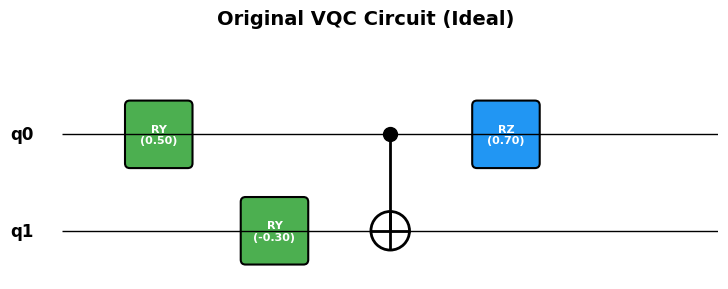

In [11]:
# Define a simple VQC circuit
vqc_circuit = [
    ("RY", [0], 0.5),
    ("RY", [1], -0.3),
    ("CNOT", [0, 1]),
    ("RZ", [0], 0.7),
]

print("=== ORIGINAL CIRCUIT (No Noise) ===")
for op in vqc_circuit:
    print(f"  {op}")

draw_circuit(vqc_circuit, n_qubits, title="Original VQC Circuit (Ideal)")
plt.show()

=== NOISY CIRCUIT (T1=100μs, T2=80μs) ===
  T1T2_NOISE on q0: λ1=0.0002, λ2=0.000094, idle=0.0μs
  ('RY', [0], 0.5)
  T1T2_NOISE on q1: λ1=0.0002, λ2=0.000094, idle=0.0μs
  ('RY', [1], -0.3)
  T1T2_NOISE on q0: λ1=0.0020, λ2=0.000749, idle=0.2μs
  T1T2_NOISE on q1: λ1=0.0020, λ2=0.000749, idle=0.2μs
  ('CNOT', [0, 1])
  ('RZ', [0], 0.7)


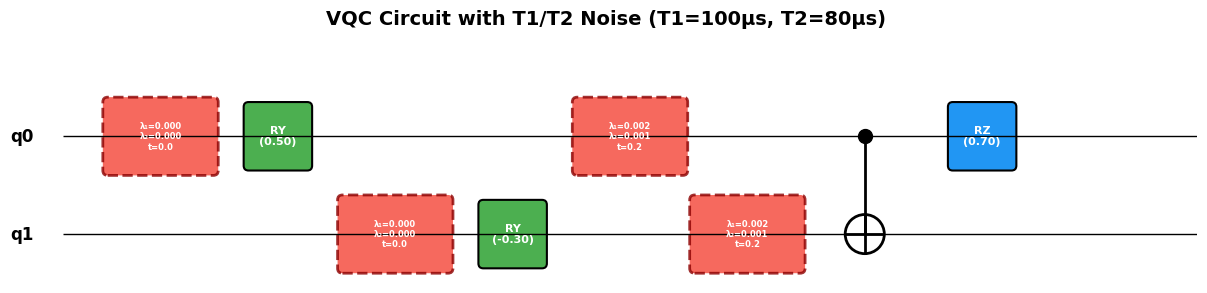

In [12]:
# Add T1/T2 noise to the circuit
T1 = 100  # microseconds (typical for superconducting qubits)
T2 = 80

noisy_circuit = add_time_based_noise(
    circuit=vqc_circuit,
    num_qubits=n_qubits,
    T1=T1,
    T2=T2,
)

print(f"=== NOISY CIRCUIT (T1={T1}μs, T2={T2}μs) ===")
for op in noisy_circuit:
    if op[0] == 'T1T2_NOISE':
        print(f"  {op[0]} on q{op[1][0]}: λ1={op[2]:.4f}, λ2={op[3]:.6f}, idle={op[4]:.1f}μs")
    else:
        print(f"  {op}")

draw_circuit(noisy_circuit, n_qubits, 
             title=f"VQC Circuit with T1/T2 Noise (T1={T1}μs, T2={T2}μs)",
             figsize=(14, 3))
plt.show()

---
## 4. Deep VQC Architecture

Our deep variational quantum circuit uses multiple layers of parameterized gates.

=== DEEP VQC (3 layers) ===
Total gates: 14
Trainable parameters: 9


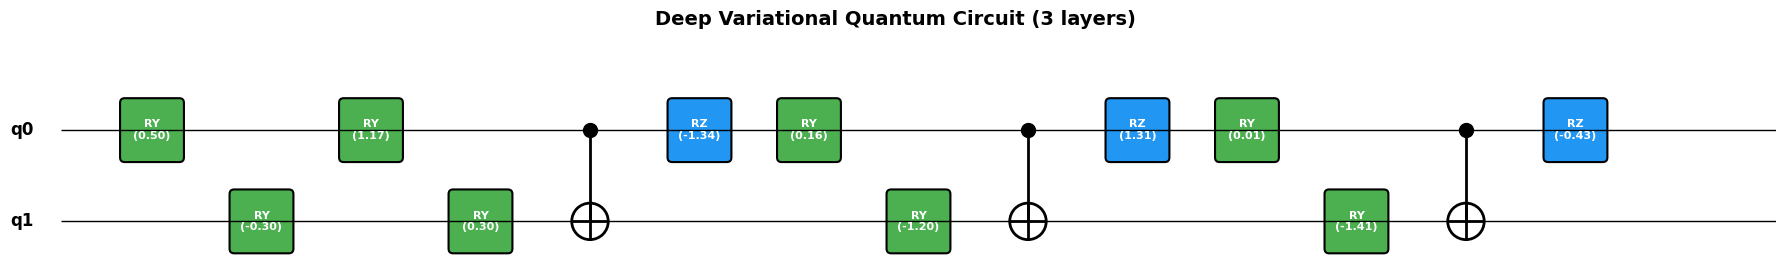

In [13]:
# Build a 3-layer deep VQC circuit
depth = 3
x_input = torch.tensor([0.5, -0.3])
theta = torch.randn(depth * 3)  # 3 parameters per layer

# Construct the full circuit
deep_vqc = []

# Encoding layer
deep_vqc += param_gate_layer("RY", x_input)

# Variational layers
idx = 0
for layer in range(depth):
    deep_vqc.append(("RY", [0], theta[idx].item()))
    deep_vqc.append(("RY", [1], theta[idx+1].item()))
    deep_vqc.append(("CNOT", [0, 1]))
    deep_vqc.append(("RZ", [0], theta[idx+2].item()))
    idx += 3

print(f"=== DEEP VQC ({depth} layers) ===")
print(f"Total gates: {len(deep_vqc)}")
print(f"Trainable parameters: {len(theta)}")

draw_circuit(deep_vqc, n_qubits, 
             title=f"Deep Variational Quantum Circuit ({depth} layers)",
             figsize=(18, 3))
plt.show()


=== NOISY DEEP VQC (T1=100μs, T2=80μs) ===
Original gates: 14
With noise operations: 28


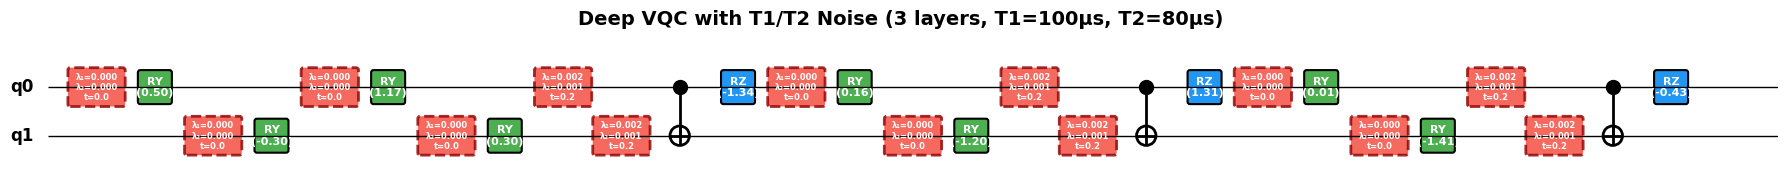

In [14]:
# Add T1/T2 noise to the deep VQC circuit
T1 = 100  # microseconds (typical for superconducting qubits)
T2 = 80   # Less than 2*T1 to see pure dephasing (λ2)

noisy_deep_vqc = add_time_based_noise(
    circuit=deep_vqc,
    num_qubits=n_qubits,
    T1=T1,
    T2=T2,
)

print(f"\n=== NOISY DEEP VQC (T1={T1}μs, T2={T2}μs) ===")
print(f"Original gates: {len(deep_vqc)}")
print(f"With noise operations: {len(noisy_deep_vqc)}")
# print("\nNoise operations:")
# for op in noisy_deep_vqc:
#     if op[0] == 'T1T2_NOISE':
#         print(f"  {op[0]} on q{op[1][0]}: λ1={op[2]:.4f}, λ2={op[3]:.6f}, idle={op[4]:.1f}μs")
#     else:
#         print(f"  {op}")

draw_circuit(noisy_deep_vqc, n_qubits, 
             title=f"Deep VQC with T1/T2 Noise ({depth} layers, T1={T1}μs, T2={T2}μs)",
             figsize=(18, 4))
plt.show()

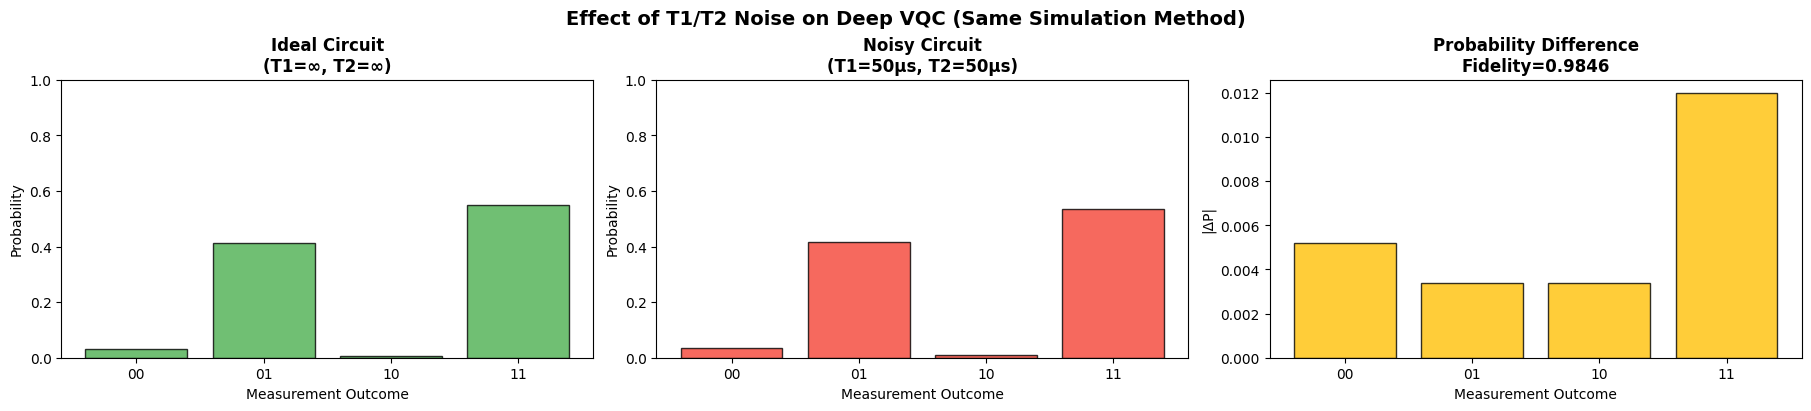

Since this circuit is so small, errors have little time to happen. See the gate times (μs): {'CNOT': 0.2, 'RY': 0.025, 'H': 0.025}


In [15]:
# Compare measurement outcomes: Ideal vs Noisy (Deep VQC)
SHOTS = 5000
T1 = 50
T2 = 50

init_state = zero_state(n_qubits)

clean_circuit = [op for op in deep_vqc if op[0] != "T1T2_NOISE"]
ideal_density = run_noisy_circuit_density(
    initial_state=init_state,
    circuit=clean_circuit,
    num_qubits=n_qubits,
    T1=0,
    T2=0,
)
# # Ideal execution (noise OFF: T1 inf
# ideal_density = run_noisy_circuit_density(
#     initial_state=init_state,
#     circuit=deep_vqc,
#     num_qubits=n_qubits,
#     T1=10e90,
#     T2=10e90,
# )

# Sample from ideal density matrix
probs_ideal = torch.real(torch.diag(ideal_density)).numpy()
probs_ideal = np.maximum(probs_ideal, 0)
probs_ideal = probs_ideal / probs_ideal.sum()

ideal_counts = {}
outcomes = np.random.choice(2**n_qubits, size=SHOTS, p=probs_ideal)
for o in outcomes:
    bitstr = format(o, f'0{n_qubits}b')
    ideal_counts[bitstr] = ideal_counts.get(bitstr, 0) + 1

# Noisy execution (with T1/T2 decoherence)
noisy_density = run_noisy_circuit_density(
    initial_state=init_state,
    circuit=deep_vqc,
    num_qubits=n_qubits,
    T1=T1,
    T2=T2,
)

# Sample from noisy density matrix
probs_noisy = torch.real(torch.diag(noisy_density)).numpy()
probs_noisy = np.maximum(probs_noisy, 0)
probs_noisy = probs_noisy / probs_noisy.sum()

noisy_counts = {}
outcomes = np.random.choice(2**n_qubits, size=SHOTS, p=probs_noisy)
for o in outcomes:
    bitstr = format(o, f'0{n_qubits}b')
    noisy_counts[bitstr] = noisy_counts.get(bitstr, 0) + 1

# Calculate fidelity
fidelity = torch.real(torch.trace(ideal_density @ noisy_density)).item()

# Plot comparison
basis_labels = [format(i, f'0{n_qubits}b') for i in range(2**n_qubits)]
fig, axes = plt.subplots(1, 3, figsize=(18, 4), constrained_layout=True)

# Ideal
ax = axes[0]
values = [ideal_counts.get(b, 0) / SHOTS for b in basis_labels]
ax.bar(basis_labels, values, color='#4CAF50', edgecolor='black', alpha=0.8)
ax.set_title('Ideal Circuit\n(T1=∞, T2=∞)', fontsize=12, fontweight='bold')
ax.set_ylabel('Probability')
ax.set_xlabel('Measurement Outcome')
ax.set_ylim(0, 1)

# Noisy
ax = axes[1]
values = [noisy_counts.get(b, 0) / SHOTS for b in basis_labels]
ax.bar(basis_labels, values, color='#F44336', edgecolor='black', alpha=0.8)
ax.set_title(f'Noisy Circuit\n(T1={T1}μs, T2={T2}μs)', fontsize=12, fontweight='bold')
ax.set_ylabel('Probability')
ax.set_xlabel('Measurement Outcome')
ax.set_ylim(0, 1)

# Difference
ax = axes[2]
ideal_probs = [ideal_counts.get(b, 0) / SHOTS for b in basis_labels]
noisy_probs = [noisy_counts.get(b, 0) / SHOTS for b in basis_labels]
diffs = [abs(i - n) for i, n in zip(ideal_probs, noisy_probs)]
colors = ['#FF9800' if d > 0.05 else '#FFC107' for d in diffs]
ax.bar(basis_labels, diffs, color=colors, edgecolor='black', alpha=0.8)
ax.set_title(f'Probability Difference\nFidelity={fidelity:.4f}', fontsize=12, fontweight='bold')
ax.set_ylabel('|ΔP|')
ax.set_xlabel('Measurement Outcome')

fig.suptitle('Effect of T1/T2 Noise on Deep VQC (Same Simulation Method)', fontsize=14, fontweight='bold')
plt.show()

from constants import DEFAULT_GATE_DURATIONS
print("Since this circuit is so small, errors have little time to happen. See the gate times (μs):", DEFAULT_GATE_DURATIONS)

check fidel: 1.0000004768371582


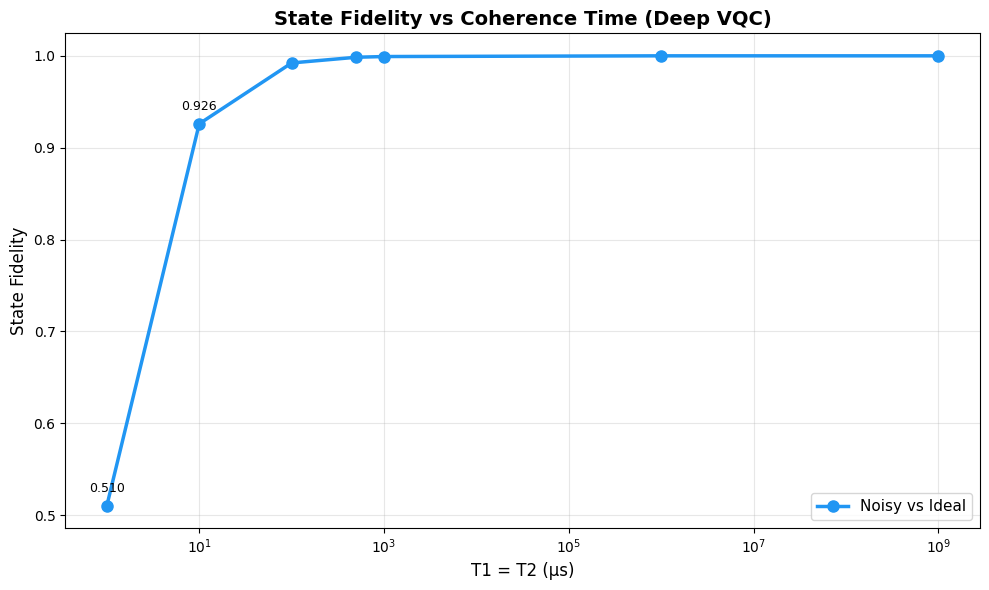


FIDELITY SUMMARY (Deep VQC: Ideal T1=∞ vs Noisy T1=T2)
T1=1.00e+00μs, T2=1.00e+00μs → F=0.5104 (degradation:  49.0%)
T1=1.00e+01μs, T2=1.00e+01μs → F=0.9260 (degradation:   7.4%)
T1=1.00e+02μs, T2=1.00e+02μs → F=0.9922 (degradation:   0.8%)
T1=5.00e+02μs, T2=5.00e+02μs → F=0.9984 (degradation:   0.2%)
T1=1.00e+03μs, T2=1.00e+03μs → F=0.9992 (degradation:   0.1%)
T1=1.00e+06μs, T2=1.00e+06μs → F=1.0000 (degradation:   0.0%)
T1=1.00e+09μs, T2=1.00e+09μs → F=1.0000 (degradation:  -0.0%)


In [16]:
# Sweep over different noise levels (Deep VQC)
T1_values = [1, 10, 100, 500, 1000, 1e6, 1e9]  # μs
T2_values = T1_values  # T2 = T1 for simplicity
fidelities = []

init_state = zero_state(n_qubits)

# # Reference: ideal state (noise OFF, T1,T2 = \inf)
# ideal_density = run_noisy_circuit_density(
#     initial_state=init_state,
#     circuit=deep_vqc,
#     num_qubits=n_qubits,
#     T1=10e90,
#     T2=10e90,
# )
clean_circuit = [op for op in deep_vqc if op[0] != "T1T2_NOISE"]
ideal_density = run_noisy_circuit_density(
    initial_state=init_state,
    circuit=clean_circuit,
    num_qubits=n_qubits,
    T1=0,
    T2=0,
)
for T1, T2 in zip(T1_values, T2_values):
    noisy_density = run_noisy_circuit_density(
        initial_state=init_state,
        circuit=deep_vqc,
        num_qubits=n_qubits,
        T1=T1,
        T2=T2,
    )
    fidelity = torch.real(torch.trace(ideal_density @ noisy_density)).item()
    fidelities.append(fidelity)

print(f"check fidel: {torch.real(torch.trace(ideal_density @ ideal_density)).item()}")

# Plot fidelity vs T1
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(T1_values, fidelities, 'o-', markersize=8, linewidth=2.5,
        color='#2196F3', label='Noisy vs Ideal')
# ax.axhline(y=1.0, color='green', linestyle='--', alpha=0.6, linewidth=2,
#            label='Perfect Fidelity (F=1)')
# ax.axhline(y=0.9, color='orange', linestyle=':', alpha=0.5, linewidth=1.5,
#            label='Good Fidelity (F=0.9)')

ax.set_xlabel('T1 = T2 (μs)', fontsize=12)
ax.set_ylabel('State Fidelity', fontsize=12)
ax.set_title('State Fidelity vs Coherence Time (Deep VQC)', fontsize=14, fontweight='bold')
ax.set_xscale('log')
# ax.set_ylim(0.1, 1.01)
ax.grid(True, alpha=0.3, which='both')
ax.legend(fontsize=11, loc='lower right')

for x, y in zip(T1_values, fidelities):
    if y < 0.95:
        ax.annotate(f'{y:.3f}', (x, y), textcoords="offset points",
                    xytext=(0, 10), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("FIDELITY SUMMARY (Deep VQC: Ideal T1=∞ vs Noisy T1=T2)")
print("="*60)
for (t1, t2), f in zip(zip(T1_values, T2_values), fidelities):
    deg_pct = (1 - f) * 100
    print(f"T1={t1:>8.2e}μs, T2={t2:>8.2e}μs → F={f:.4f} (degradation: {deg_pct:5.1f}%)")
print("="*60)

In [17]:
depth = 3
x_input = torch.tensor([0.5, -0.3])
theta = torch.randn(depth * 3)

deep_vqc_clean = []
deep_vqc_clean += param_gate_layer("RY", x_input)

idx = 0
for layer in range(depth):
    deep_vqc_clean.append(("RY", [0], theta[idx].item()))
    deep_vqc_clean.append(("RY", [1], theta[idx+1].item()))
    deep_vqc_clean.append(("CNOT", [0, 1]))
    deep_vqc_clean.append(("RZ", [0], theta[idx+2].item()))
    idx += 3

# NOW use this for ideal
ideal_density = run_noisy_circuit_density(
    initial_state=zero_state(n_qubits),
    circuit=deep_vqc_clean,
    num_qubits=n_qubits,
    T1=0,
    T2=0,
)

print(f"check fidel: {torch.real(torch.trace(ideal_density @ ideal_density)).item()}")

check fidel: 1.0000005960464478


In [18]:
trivial_circuit = [("H", [0])]  # Just one Hadamard

test_density = run_noisy_circuit_density(
    initial_state=zero_state(2),
    circuit=trivial_circuit,
    num_qubits=2,
    T1=0,
    T2=0,
)

purity = torch.real(torch.trace(test_density @ test_density)).item()
print(f"Purity of H|00⟩: {purity}")  # Should be ~1.0

Purity of H|00⟩: 0.9999998807907104


In [19]:
print("First 10 ops in deep_vqc_clean:")
for i, op in enumerate(deep_vqc_clean[:10]):
    print(f"  {i}: {op}")
    # Check for NaN/Inf in parameters
    if len(op) > 2 and op[2] is not None:
        param = op[2]
        if isinstance(param, torch.Tensor):
            if torch.isnan(param).any() or torch.isinf(param).any():
                print(f"       ⚠ BAD PARAM: {param}")
        elif isinstance(param, float):
            if math.isnan(param) or math.isinf(param):
                print(f"       ⚠ BAD PARAM: {param}")

print(f"\nTotal ops: {len(deep_vqc_clean)}")

First 10 ops in deep_vqc_clean:
  0: ('RY', [0], tensor(0.5000))
  1: ('RY', [1], tensor(-0.3000))
  2: ('RY', [0], 1.0908966064453125)
  3: ('RY', [1], 0.7662184238433838)
  4: ('CNOT', [0, 1])
  5: ('RZ', [0], -0.38620418310165405)
  6: ('RY', [0], -1.9084150791168213)
  7: ('RY', [1], 2.223785638809204)
  8: ('CNOT', [0, 1])
  9: ('RZ', [0], -1.0458203554153442)

Total ops: 14


In [20]:
# What does the encoding layer look like?
encoding = param_gate_layer("RY", torch.tensor([0.5, -0.3]))
print(f"Encoding layer ({len(encoding)} ops):")
for op in encoding:
    print(f"  {op}")

Encoding layer (2 ops):
  ('RY', [0], tensor(0.5000))
  ('RY', [1], tensor(-0.3000))


In [21]:
# Test: 2 CNOTs
two_cnots = [("CNOT", [0, 1]), ("CNOT", [0, 1])]
test_density = run_noisy_circuit_density(
    initial_state=zero_state(2),
    circuit=two_cnots,
    num_qubits=2,
    T1=0,
    T2=0,
)
purity = torch.real(torch.trace(test_density @ test_density)).item()
print(f"Purity after 2 CNOTs: {purity}")

Purity after 2 CNOTs: 1.0


In [22]:
# Test: one RY
one_ry = [("RY", [0], 0.5)]
test_density = run_noisy_circuit_density(
    initial_state=zero_state(2),
    circuit=one_ry,
    num_qubits=2,
    T1=0,
    T2=0,
)
purity = torch.real(torch.trace(test_density @ test_density)).item()
print(f"Purity after 1 RY: {purity}")

# Test: two RYs in sequence
two_rys = [("RY", [0], 0.5), ("RY", [1], -0.3)]
test_density = run_noisy_circuit_density(
    initial_state=zero_state(2),
    circuit=two_rys,
    num_qubits=2,
    T1=0,
    T2=0,
)
purity = torch.real(torch.trace(test_density @ test_density)).item()
print(f"Purity after RY+RY: {purity}")

# Test: RY then CNOT
ry_cnot = [("RY", [0], 0.5), ("CNOT", [0, 1])]
test_density = run_noisy_circuit_density(
    initial_state=zero_state(2),
    circuit=ry_cnot,
    num_qubits=2,
    T1=0,
    T2=0,
)
purity = torch.real(torch.trace(test_density @ test_density)).item()
print(f"Purity after RY+CNOT: {purity}")

Purity after 1 RY: 1.000000238418579
Purity after RY+RY: 1.000000238418579
Purity after RY+CNOT: 1.000000238418579


In [23]:
one_ry = [("RY", [0], 0.5)]
test_density = run_noisy_circuit_density(
    initial_state=zero_state(2),
    circuit=one_ry,
    num_qubits=2,
    T1=0,
    T2=0,
)
purity = torch.real(torch.trace(test_density @ test_density)).item()
print(f"Purity after 1 RY: {purity}")  # Should now be ~1.0

Purity after 1 RY: 1.000000238418579
